## Parameters

In [1]:
CLUSTER_ALGO = "KMeans"
NC = 21
CLUSTER_STD = 1.0
N_P_CLUSTERS = [3,30, 100, 300, 3000]
OUTER_FOLD = 5
INNER_FOLD =10


## IMPORTS

In [2]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons





In [3]:
%load_ext autoreload
%autoreload 2
packages = !conda list
packages

['# packages in environment at /opt/conda:',
 '#',
 '# Name                    Version                   Build  Channel',
 '_libgcc_mutex             0.1                 conda_forge    conda-forge',
 '_openmp_mutex             4.5                       0_gnu    conda-forge',
 'alembic                   1.4.2              pyh9f0ad1d_0    conda-forge',
 'astroid                   2.4.1                    pypi_0    pypi',
 'astunparse                1.6.3                    pypi_0    pypi',
 'async_generator           1.10                       py_0    conda-forge',
 'attrs                     19.3.0                     py_0    conda-forge',
 'backcall                  0.1.0                      py_0    conda-forge',
 'bleach                    3.1.4              pyh9f0ad1d_0    conda-forge',
 'blinker                   1.4                        py_1    conda-forge',
 'brotlipy                  0.7.0           py37h8f50634_1000    conda-forge',
 'ca-certificates           2020.4.5.1     

In [4]:
!pwd


/docker/photon_experiments


## Output registry

In [5]:
from __future__ import print_function
import sys, os

old__file__ = !pwd
__file__ = !cd ../photon ;pwd
#__file__ = !pwd
__file__ = __file__[0]
__file__
sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
old__file__[0]

['/docker/photon_experiments', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/docker/photon']
/docker/photon_experiments


'/docker/photon_experiments'

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


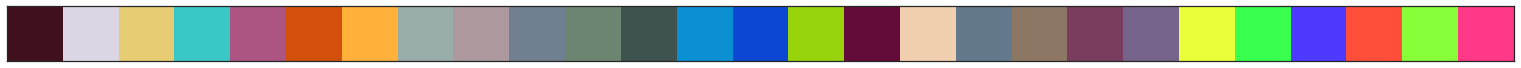

In [6]:

import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from math import ceil
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette 
customPalette = ['#40111D', '#DCD5E4', '#E7CC74'
                 ,'#39C8C6', '#AC5583', '#D3500C'
                 ,'#FFB139', '#98ADA7', '#AD989E'
                 ,'#708090','#6C8570','#3E534D'
                 ,'#0B8FD3','#0B47D3','#96D30B'                 
                 ,'#630C3A','#F1D0AF','#64788B'                 
                 ,'#8B7764','#7A3C5D','#77648B'
                 ,'#eaff39','#39ff4e','#4e39ff'
                 ,'#ff4e39','#87ff39','#ff3987', ]
sns.set_palette(customPalette)
sns.palplot(customPalette)


from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

from photonai.base import Hyperpipe, PipelineElement, Preprocessing, OutputSettings
from photonai.optimization import FloatRange, Categorical, IntegerRange
from photonai.base.photon_elements import PhotonRegistry
from photonai.visual.graphics import plot_cm
#from photonai.base.registry.registry import PhotonRegistry

In [7]:
def results_to_df(results):
    ll = []
    for obj in results:
        ll.append([obj.operation,
        obj.value,
        obj.metric_name])
    _results=pd.DataFrame(ll).pivot(index=2, columns=0, values=1)
    _results.columns=['Mean','STD']
    
    return(_results)

In [8]:
def cluster_plot(my_pipe, data_X, customPalette):
    y_pred= my_pipe.predict(data_X)
    data = pd.DataFrame(data_X[:, 0],columns=['x'])
    data['y'] = data_X[:, 1]
    data['labels'] = y_pred
    facet = sns.lmplot(data=data, x='x', y='y', hue='labels', 
                       aspect= 1.0, height=7,
               fit_reg=False, legend=True, legend_out=True)

    for i, label in enumerate( np.sort(data['labels'].unique())):
        plt.annotate(label, 
                     data.loc[data['labels']==label,['x','y']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=10, weight='bold',
                     color='white',
                     backgroundcolor=customPalette[i]) 

    plt.show()
    return y_pred

In [9]:
__file__ = "exp1.log"
base_folder = os.path.dirname(os.path.abspath(''))
custom_elements_folder = os.path.join(base_folder, 'custom_elements')
custom_elements_folder

'/docker/custom_elements'

In [10]:
registry = PhotonRegistry(custom_elements_folder=custom_elements_folder)
registry.activate()
registry.PHOTON_REGISTRIES,PhotonRegistry.PHOTON_REGISTRIES

(['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'],
 ['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'])

In [11]:
registry.activate()
registry.list_available_elements()
# take off last name


PhotonCore
ARDRegression                       sklearn.linear_model.ARDRegression                                          Estimator
AdaBoostClassifier                  sklearn.ensemble.AdaBoostClassifier                                         Estimator
AdaBoostRegressor                   sklearn.ensemble.AdaBoostRegressor                                          Estimator
BaggingClassifier                   sklearn.ensemble.BaggingClassifier                                          Estimator
BaggingRegressor                    sklearn.ensemble.BaggingRegressor                                           Estimator
BayesianGaussianMixture             sklearn.mixture.BayesianGaussianMixture                                     Estimator
BayesianRidge                       sklearn.linear_model.BayesianRidge                                          Estimator
BernoulliNB                         sklearn.naive_bayes.BernoulliNB                                             Estimator
BernoulliRBM

## KMedoids yield_parameters_ellipse

In [12]:
registry.info(CLUSTER_ALGO)

----------------------------------
Name: KMeans
Namespace: sklearn.cluster
----------------------------------
Possible Hyperparameters as derived from constructor:
n_clusters                          n_clusters=8                                                               
init                                init='k-means++'                                                           
n_init                              n_init=10                                                                  
max_iter                            max_iter=300                                                               
tol                                 tol=0.0001                                                                 
precompute_distances                precompute_distances='auto'                                                
verbose                             verbose=0                                                                  
random_state                        random_state=Non

('KMeans',
 'sklearn.cluster',
 {'n_clusters': 'n_clusters',
  'init': 'init',
  'n_init': 'n_init',
  'max_iter': 'max_iter',
  'tol': 'tol',
  'precompute_distances': 'precompute_distances',
  'verbose': 'verbose',
  'random_state': 'random_state',
  'copy_x': 'copy_x',
  'n_jobs': 'n_jobs',
  'algorithm': 'algorithm'})

In [13]:
def yield_parameters_ellipse(n_p_clusters):
    n_cluster = NC
    cluster_std = CLUSTER_STD
    for n_p_cluster in n_p_clusters:
        n_cluster_std = [cluster_std for k in range(n_cluster)]
        n_samples = [n_p_cluster for k in range(n_cluster)]
        data_X, data_y = make_blobs(n_samples=n_samples,
                                   cluster_std=n_cluster_std, random_state=0)
        transformation = [[0.6, -0.6], [-0.4, 0.8]]
        X_ellipse = np.dot(data_X, transformation)
        yield [X_ellipse, data_y]

In [14]:
def hyper_cluster(cluster_name):
    
    n_p_clusters = N_P_CLUSTERS 

    for data_X, data_y  in yield_parameters_ellipse(n_p_clusters):
        print('n_points:', len(data_y))
        """
        Example script for KMedoids hopt
        """
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')

        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits= OUTER_FOLD),
                            inner_cv=KFold(n_splits=INNER_FOLD),
                            verbosity=0,
                            output_settings=settings)


        my_pipe += PipelineElement(cluster_name, hyperparameters={
                                                           'n_clusters': IntegerRange(1, ceil(NC*1.2)),
                                                            },random_state=777)

        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True
    #------------------------------plot
        y_pred=cluster_plot(my_pipe, X, customPalette)
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

n_points: 63
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

********************************************************
Outer Cross validation Fold 1
********************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
---------------------------------------------------------------------------------------------------------------
{
    "KMeans": [
        "n_clusters=21"
    ]
}
+--------+-------------------+------------------+
| METRIC | PERFORMANCE TRAIN | PERFORMANCE TEST |
+--------+-------------------+------------------+
|  ARI   |       0.4290      |      0.5551      |
|   MI   |       0.5088      |      0.6116      |
|  HCV   |       0.8402      |      0.8922      |
|   F

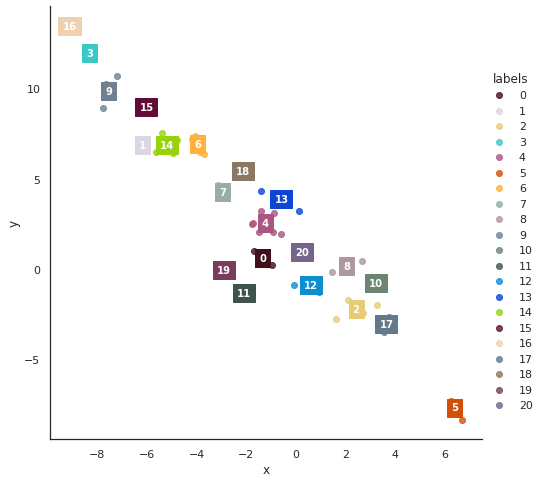

           n_clusters   k
0  KMeans__n_clusters  21
train 
          Mean       STD
2                      
ARI  0.409516  0.032290
FM   0.437950  0.026368
HCV  0.825726  0.032672
MI   0.495250  0.026981
test 
          Mean       STD
2                      
ARI  0.215285  0.226722
FM   0.261593  0.243286
HCV  0.861373  0.055042
MI   0.243227  0.252129
            jaccard_index      0.24427480916030533
               rand_index       0.9493087557603687
            adjrand_index       0.3676076653616323
    fowlkes_mallows_index       0.4031621045431757
                 fmeasure      0.39263803680981596
             purity_index       0.6507936507936507
     classification_error       0.3492063492063493
        czekanowski_index      0.39263803680981596
               dice_index      0.39263803680981596
           sorensen_index      0.39263803680981596
    rogers_tanimoto_index       0.9035087719298246
          southwood_index      0.32323232323232326
      pearson_correlation   2.546

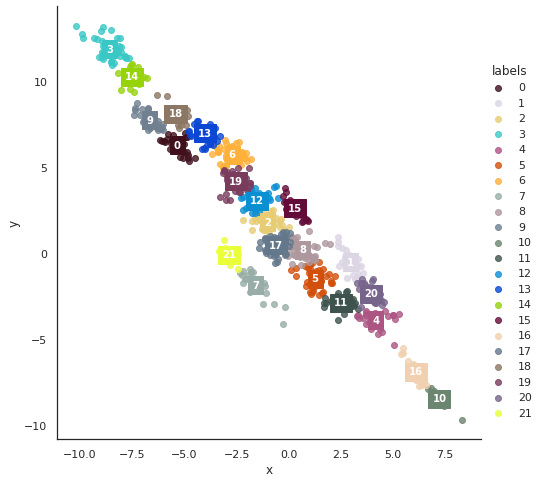

           n_clusters   k
0  KMeans__n_clusters  22
train 
          Mean       STD
2                      
ARI  0.393825  0.015105
FM   0.425482  0.011597
HCV  0.677058  0.031103
MI   0.622544  0.007732
test 
          Mean       STD
2                      
ARI  0.376591  0.042410
FM   0.409246  0.040478
HCV  0.725325  0.036343
MI   0.526235  0.044046
            jaccard_index      0.28717566560531127
               rand_index       0.9468947939536175
            adjrand_index      0.41836392669545147
    fowlkes_mallows_index       0.4465402343130278
                 fmeasure      0.44621052631578945
             purity_index       0.6285714285714286
     classification_error      0.37142857142857144
        czekanowski_index      0.44621052631578945
               dice_index      0.44621052631578945
           sorensen_index      0.44621052631578945
    rogers_tanimoto_index       0.8991454875705105
          southwood_index       0.4028701767724767
      pearson_correlation    2.33

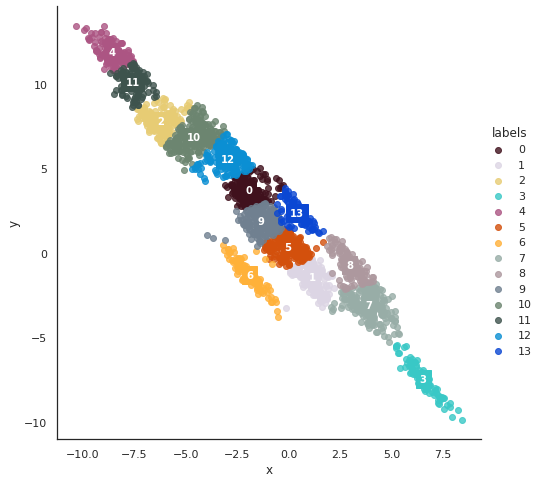

           n_clusters   k
0  KMeans__n_clusters  14
train 
          Mean       STD
2                      
ARI  0.389412  0.011488
FM   0.437362  0.015963
HCV  0.604299  0.004716
MI   0.640496  0.006892
test 
          Mean       STD
2                      
ARI  0.388908  0.021898
FM   0.436786  0.019238
HCV  0.619543  0.020265
MI   0.617243  0.014731
            jaccard_index       0.2665055010573582
               rand_index       0.9285505569545589
            adjrand_index      0.38501841998716885
    fowlkes_mallows_index       0.4330184074379752
                 fmeasure       0.4208517070551414
             purity_index      0.47904761904761906
     classification_error        0.520952380952381
        czekanowski_index       0.4208517070551414
               dice_index       0.4208517070551414
           sorensen_index       0.4208517070551414
    rogers_tanimoto_index       0.8666303043802863
          southwood_index      0.36333674136825195
      pearson_correlation    1.45

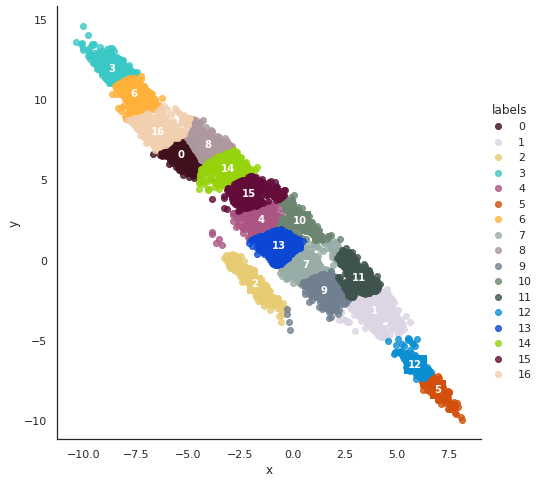

           n_clusters   k
0  KMeans__n_clusters  17
train 
          Mean       STD
2                      
ARI  0.374624  0.006981
FM   0.417979  0.009489
HCV  0.597311  0.010195
MI   0.630866  0.006085
test 
          Mean       STD
2                      
ARI  0.372284  0.017046
FM   0.415803  0.012165
HCV  0.602325  0.016726
MI   0.623744  0.008749
            jaccard_index      0.25153989999202697
               rand_index       0.9332914521579389
            adjrand_index       0.3674727548506879
    fowlkes_mallows_index      0.40650124281515515
                 fmeasure      0.40196864677447264
             purity_index       0.4884126984126984
     classification_error       0.5115873015873016
        czekanowski_index      0.40196864677447264
               dice_index      0.40196864677447264
           sorensen_index      0.40196864677447264
    rogers_tanimoto_index       0.8749263836368205
          southwood_index       0.3360765657238741
      pearson_correlation    1.81

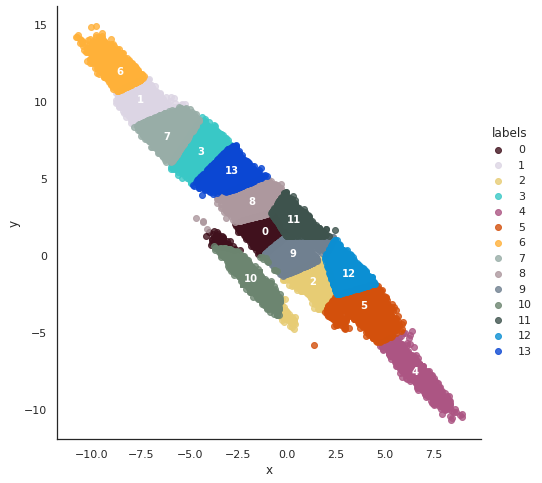

           n_clusters   k
0  KMeans__n_clusters  14
train 
          Mean       STD
2                      
ARI  0.367076  0.005600
FM   0.411438  0.005472
HCV  0.589217  0.011353
MI   0.626443  0.006320
test 
          Mean       STD
2                      
ARI  0.367457  0.004698
FM   0.411716  0.004716
HCV  0.590303  0.011412
MI   0.626375  0.006059
            jaccard_index      0.25657737817334764
               rand_index       0.9264604446984167
            adjrand_index       0.3714503189921888
    fowlkes_mallows_index      0.42004220300611966
                 fmeasure      0.40837497575569476
             purity_index       0.4659206349206349
     classification_error       0.5340793650793652
        czekanowski_index      0.40837497575569476
               dice_index      0.40837497575569476
           sorensen_index      0.40837497575569476
    rogers_tanimoto_index       0.8629960956009223
          southwood_index        0.345129904095352
      pearson_correlation   1.718

In [ ]:
hyper_cluster(CLUSTER_ALGO)